# **GWP3**

## **Team Member 1**

In [ ]:
!pip install yfinance &> /dev/null
!pip install arch &> /dev/null

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from arch.unitroot import ADF, KPSS
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen


plt.rcParams["figure.figsize"] = (12, 9)


import warnings
warnings.filterwarnings('ignore')

For our Modeling I am going to use 5 years of daily data from 2019-2024 using yahoo finance API, the data we are collecting are from 3 major liquid ETF's SPY (SPDR S&P 500 ETF Trust), QQQ (Invesco QQQ Trust), VGT (Vanguard Information Technology Index Fund ETF Shares).




---



* Reasons for selcting these ETF's :

> 1.   Market represntation
2.   Liquidity
3.   Sector Diversification


Overall, selecting these ETF's for analysis provides a balanced representation of the market, ensures data reliability due to high liquidity, and allows for insights into both broad market trends and sector-specific dynamics, especially in the technology sector.













In [ ]:
def assets(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        try:
            data = yf.download(ticker, start='2019-04-01', end='2024-04-01')
            data.dropna(inplace=True)
            data = data[['Adj Close']].reset_index()
            data.rename(columns={'Adj Close': ticker}, inplace=True)
        except Exception as e:
            print(f"Failed to retrieve data for {ticker}: {str(e)}")
        if df.empty:
          df = data
        else:
          df = pd.merge(df, data, on='Date', how='outer')
    df.dropna(inplace=True)
    return df

In [ ]:
tickers = ['SPY', 'QQQ', 'VGT']

In [ ]:
T1_df = assets(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
T1_df

,Date,SPY,QQQ,VGT
0,2019-04-01,263.752014,176.232605,194.335678
1,2019-04-02,263.881317,176.900589,194.889709
2,2019-04-03,264.296478,177.917130,196.532715
3,2019-04-04,264.997864,177.849365,195.481964
4,2019-04-05,266.280396,178.769043,196.408539
...,...,...,...,...
1253,2024-03-22,521.210022,446.380005,528.280029
1254,2024-03-25,519.770020,444.760010,526.150024
1255,2024-03-26,518.809998,443.320007,523.840027
1256,2024-03-27,523.169983,444.829987,525.080017


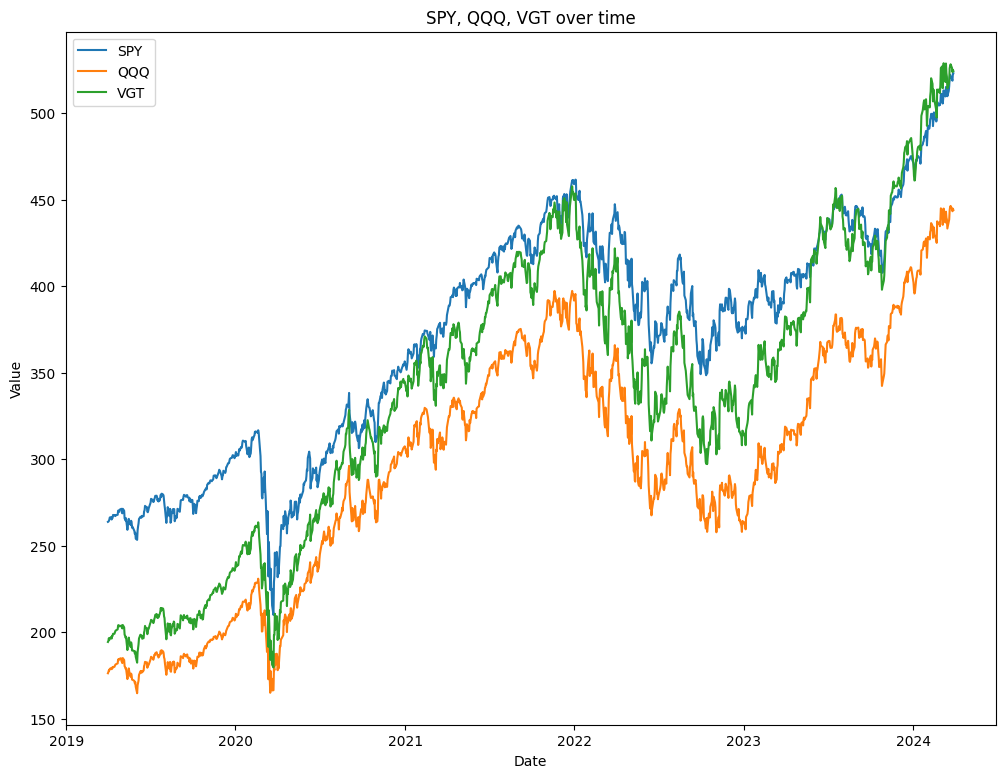

In [ ]:
# Time series Plot
plt.plot(T1_df['Date'], T1_df['SPY'], label='SPY')
plt.plot(T1_df['Date'], T1_df['QQQ'], label='QQQ')
plt.plot(T1_df['Date'], T1_df['VGT'], label='VGT')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SPY, QQQ, VGT over time')
_ = plt.legend()

As you can see in Figure 1, All the ETF's are moving together in a similar trend. So we will now first do some visualization check for stationarity and after that we will do some econometric test for stationarity.

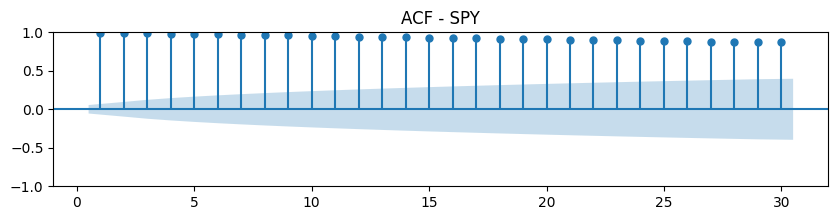

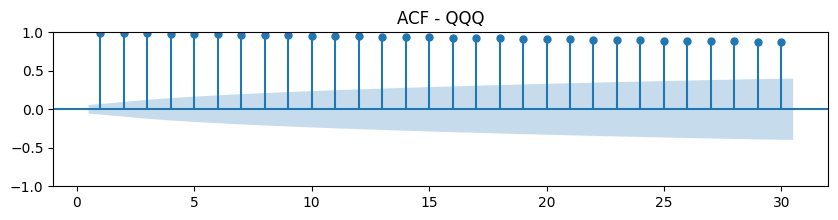

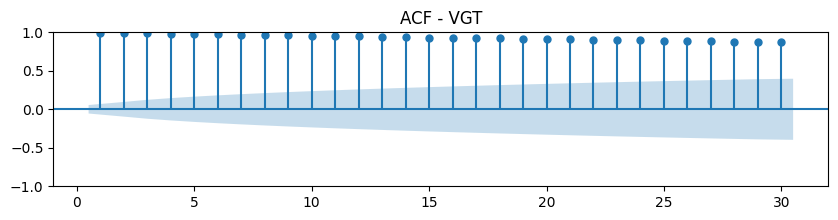

In [ ]:
#ACF Plot
for idx, col in enumerate(T1_df.columns):
    if idx > 0:
        fig, ax = plt.subplots(figsize=(10, 2))
        SIGNIFICANCE_LEVEL = 0.05

        plot_acf(T1_df[col], zero=False, ax=ax,
                 lags=30, alpha=SIGNIFICANCE_LEVEL, title=f'ACF - {col}')

        plt.show()

In this Figure 2, we can see the plot of ACF plot for each ETF price. In the ACF diagrams we can see a slow decay suggestion non-stationarity.

Now we will do some Econometrics tests like ADF and KPSS tests to check for stationarity.

In [ ]:
# ADF Test Results with 5% Significance Level
spy_adf = ADF(T1_df['SPY'], trend="n", method="bic")
qqq_adf = ADF(T1_df['QQQ'], trend="n", method="bic")
vgt_adf = ADF(T1_df['VGT'], trend="n", method="bic")


pd.DataFrame(
    {
        "SPY Price": (spy_adf.stat,  spy_adf.critical_values["5%"]),
        "| QQQ Price": (qqq_adf.stat,  qqq_adf.critical_values["5%"]),
        "| GLD Price": (vgt_adf.stat, vgt_adf.critical_values["5%"],),
    },
    index=["ADF Test Statistic", "5% Critical Value"],
)

,SPY Price,| QQQ Price,| GLD Price
ADF Test Statistic,1.700658,1.474284,1.467270
5% Critical Value,-1.941216,-1.941216,-1.941216


In the ADF results you can see none of the ETF's prices has test statistic is greater than 5% critical value so we cannot reject the $H_0$ (null) Hypothesis and there are unit roots in all three time series.

Now let's do KPSS tests :

In [ ]:
# KPSS Test
print(KPSS(T1_df['SPY'], trend="ct", lags=-1))
print(KPSS(T1_df['QQQ'], trend="ct", lags=-1))
print(KPSS(T1_df['VGT'], trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  0.577
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.653
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.595
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant and Linear Time T

Here in the Result of KPSS test we can see all the time series have p-value lower than 0.05, which clearly reject the $H_0$ hypothesis, which means all these time series are non stationary and has unit root.

Now to verify our results of non-stationarity we will do differencing of the time series data and again do the visualization and econometric tests to check if the data becomes stationary or not.

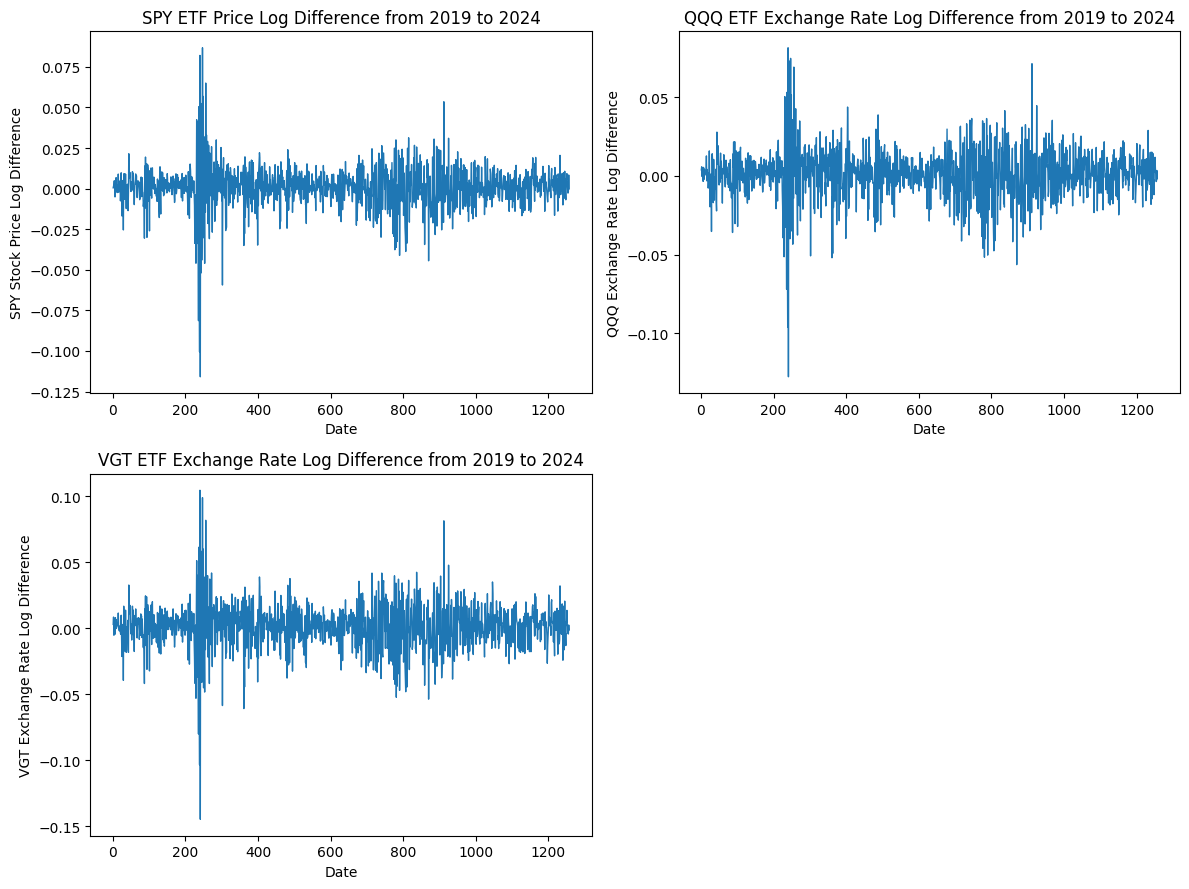

In [ ]:
# First difference time plot

fig, axs = plt.subplots(2, 2)

d_spy = np.log(T1_df['SPY']).diff().dropna()
d_spy.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="SPY Stock Price Log Difference",
    title="SPY ETF Price Log Difference from 2019 to 2024",
    ax=axs[0, 0],
)

d_qqq = np.log(T1_df['QQQ']).diff().dropna()
d_qqq.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="QQQ Exchange Rate Log Difference",
    title="QQQ ETF Exchange Rate Log Difference from 2019 to 2024",
    ax=axs[0, 1],
)

d_vgt = np.log(T1_df['VGT']).diff().dropna()
d_vgt.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="VGT Exchange Rate Log Difference",
    title="VGT ETF Exchange Rate Log Difference from 2019 to 2024",
    ax=axs[1, 0],
)

axs[1, 1].axis("off")
fig.tight_layout()
plt.show()

In this Figure 3, we can see the time series plot of the differenced data of the ETF prices.

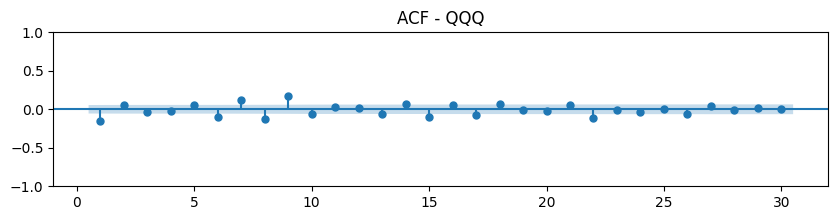

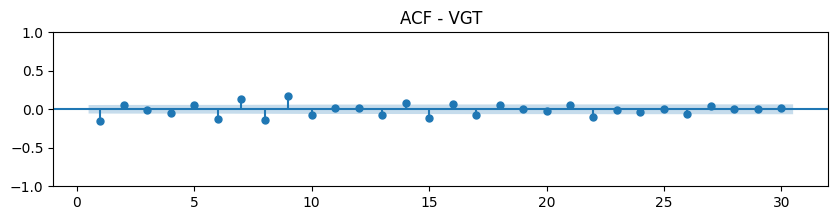

In [ ]:
ACF_T1_diff = pd.concat(
    [d_spy, d_qqq, d_vgt], axis=1
)

#ACF Plot
for idx, col in enumerate(ACF_T1_diff.columns):
    if idx > 0:
        fig, ax = plt.subplots(figsize=(10, 2))
        SIGNIFICANCE_LEVEL = 0.05

        plot_acf(ACF_T1_diff[col], zero=False, ax=ax,
                 lags=30, alpha=SIGNIFICANCE_LEVEL, title=f'ACF - {col}')

        plt.show()

In this Figure 4, we can see the plot of ACF plot for each ETF differences price. In the ACF diagrams we can see the ACF is dropping to zero quickly suggesting stationarity.

Now we will do some Econometrics tests like ADF and KPSS tests to check for stationarity.

In [ ]:
#ADF test for difference
d_spy_adf = ADF(d_spy, trend="n", method="bic")
d_qqq_adf = ADF(d_qqq, trend="n", method="bic")
d_vgt_adf = ADF(d_vgt, trend="n", method="bic")

pd.DataFrame(
    {
        "SPY Price": (d_spy_adf.stat, d_spy_adf.critical_values["5%"]),
        "| QQQ Price": (d_qqq_adf.stat, d_qqq_adf.critical_values["5%"]),
        "| GLD Price": (d_vgt_adf.stat, d_vgt_adf.critical_values["5%"])
    },
    index=["ADF Test Statistic", "5% Critical Value"],
)

,SPY Price,| QQQ Price,| GLD Price
ADF Test Statistic,-10.413947,-10.742549,-10.972278
5% Critical Value,-1.941217,-1.941217,-1.941217


In the ADF results you can see none of the ETF's prices has test statistic is lower than 5% critical value so we can reject the $H_0$ (null) Hypothesis and there are no unit roots in all three time series.

Now let's do KPSS tests :

In [ ]:
# KPSS Test
print(KPSS(d_spy, trend="ct", lags=-1))
print(KPSS(d_qqq, trend="ct", lags=-1))
print(KPSS(d_vgt, trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  0.059
P-value                         0.464
Lags                               23
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.093
P-value                         0.194
Lags                               23
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.075
P-value                         0.306
Lags                               23
-------------------------------------

Trend: Constant and Linear Time T

Here in the Result of KPSS test we can see all the time series have p-value higher than 0.05, which cannot reject the  H0  hypothesis, which means all these time series are stationary and has no unit root.

Now as we can see in the non-differenced data all our test suggests that our dataset is non-stationary but after differencing that data we can see all the tests are suggesting that our data is stationary. this verifies our tests as well as all the assumptions to belive that our data set is non-stationary.

As we have confirmed that our data is non-stationary we will now do some regression modeling before that we need to decide the number of lags in the VEC (regression) model before testing it for cointegration.

So we will run a VAR model to select number of lags for VEC model.

In [ ]:
# Selection of Number of Lags for VEC Model
vecm_T1_df = pd.concat(
    [T1_df['SPY'], T1_df['QQQ'],T1_df['VGT']], axis=1
)

# Fit VAR model and run lag selection tool
model = VAR(vecm_T1_df)
x = model.select_order(maxlags=12, trend="c")
x.summary()

,AIC,BIC,FPE,HQIC
0,17.79,17.80,5.333e+07,17.80
1,4.216*,4.265*,67.77*,4.235*
2,4.217,4.303,67.83,4.250
3,4.217,4.341,67.83,4.263
4,4.225,4.386,68.39,4.286
5,4.233,4.430,68.91,4.307
6,4.240,4.475,69.43,4.329
7,4.245,4.516,69.74,4.347
8,4.232,4.540,68.84,4.348
9,4.233,4.579,68.91,4.363


In the above results we can see all the information criteria suggest we should select lag 1 for the level of the VAR model.

Now as we have decided number of lag, we will now check for cointegration using Johansen Trace test :

In [ ]:
# Johansen Trace Test Result for ETFs

jtest = coint_johansen(vecm_T1_df, det_order=0, k_ar_diff=1)

# Print the results
print(f"Eigenvalues of VECM coefficient matrix : {jtest.eig}\n")

pd.DataFrame(
    {
        "Test statistic": jtest.trace_stat,
        "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
        "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
        "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
    },
    index=["rank=0", "rank<=1", "rank<=2"],
)

Eigenvalues of VECM coefficient matrix : [0.01479121 0.00389053 0.00087087]



,Test statistic,Critical values (90%),Critical values (95%),Critical values (99%)
rank=0,24.706843,27.0669,29.7961,35.4628
rank<=1,5.990324,13.4294,15.4943,19.9349
rank<=2,1.094289,2.7055,3.8415,6.6349


In [ ]:
# VECM model
vecm_model = VECM(endog=vecm_T1_df, k_ar_diff=1, deterministic="ci").fit()
print(vecm_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation SPY
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.SPY        -0.1901      0.075     -2.546      0.011      -0.336      -0.044
L1.QQQ        -0.0101      0.141     -0.071      0.943      -0.286       0.266
L1.VGT         0.0968      0.113      0.856      0.392      -0.125       0.318
Det. terms outside the coint. relation & lagged endog. parameters for equation QQQ
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.SPY        -0.1887      0.075     -2.502      0.012      -0.336      -0.041
L1.QQQ        -0.0295      0.142     -0.207      0.836      -0.308       0.249
L1.VGT         0.1035      0.114      0.907      0.365      -0.120       0.327
Det. terms outside the coint. relation & lag


From the above johnsen trace test, we can see three tests: $H_0$: rank = 0, $H_1$ : rank = 1, $H_2$ : rank = 2.
We will use 5% as our decision point.

* For $H_0$: rank = 0, we can see the test statistic is 24.7068 and the 5%
critical value is 29.7961 which means the test statistic is ledd that the critical value so we do not reject the null hypothesis that there are zero cointegration relationships.

* For $H_1$: rank = 1, we can see the test statistic is 5.9903 and the 5% critical value is 15.4943 which means the test statistic is ledd that the critical value so we do not reject the null hypothesis that there are at most one cointegration relationships.

* For $H_2$: rank = 2, we can see the test statistic is 1.0942 and the 5% critical value is 3.8415 which means the test statistic is ledd that the critical value so we do not reject the null hypothesis that there are most two cointegration relationships.

Overall the Johansen Trace Test suggested that there are at most two cointegrating relationships among the variables. This means that some linear combination of the variables is stationary, indicating a long-term equilibrium relationship.

So then we ran a VEC model and using the "*Cointegration relations for loading-coefficients-column 1*" we can write the linear combination as follows :



> $S$ = -127.9209 + 1 . $SPY$ + 1.2276 . $QQQ$ - 1.7958 . $VGT$

The above equation is the devation from the long-term equilibrium of the three time series. Let's check out the plot to see if this deviation is stationary.



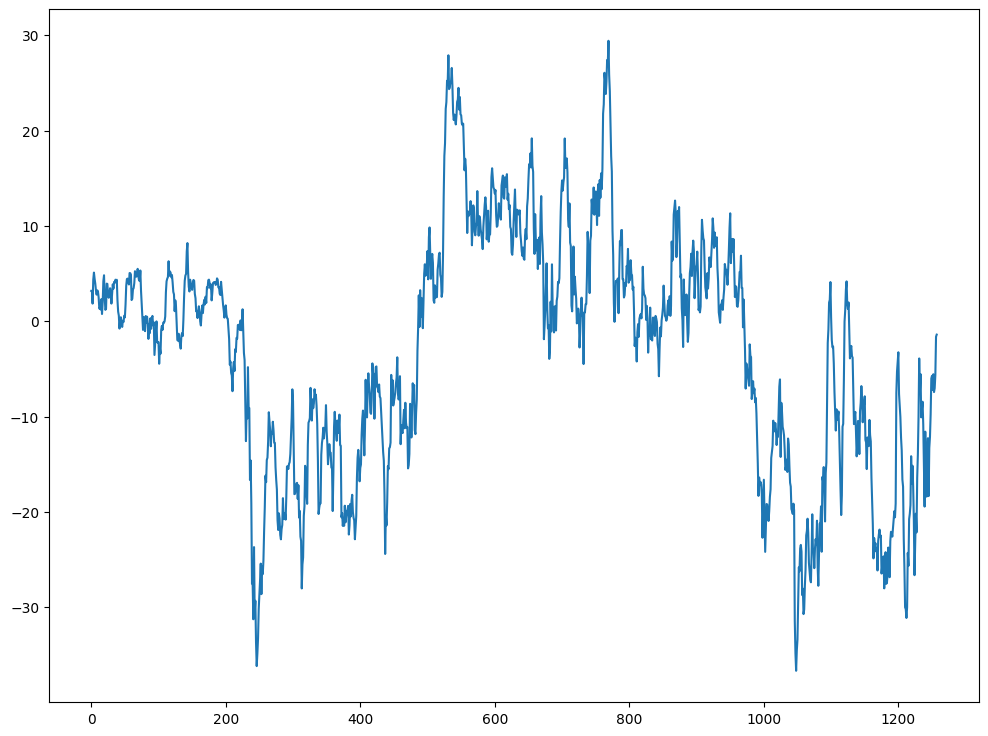

In [ ]:
# Time Plot for Deviation from Long-Term Equilibrium
"""
The precise coefficients of the linear combination are in:
vecm_model.const_coint and vecm_model.beta
S = -127.9209 + 1*SPY + 1.2276*QQQ - 1.7958*VGT
"""
S = (
    vecm_model.const_coint[0][0]
    + vecm_model.beta[0][0] * vecm_T1_df.SPY
    + vecm_model.beta[1][0] * vecm_T1_df.QQQ
    + vecm_model.beta[2][0] * vecm_T1_df.VGT
)
plt.plot(S)
plt.show()

In this Figure 5 we can see a long-term equilibrium is moving within a channel. Let's take a look at the ADF test for the deviation.

In [ ]:
# ADF Test Result for Deviation from Long-Term Equilibrium
S_adf = ADF(S, trend="n", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", S_adf.regression.summary())
print("\nTest statistics and critical values: \n", S_adf)

Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              10.29
Date:                Mon, 08 Apr 2024   Prob (F-statistic):                     0.00137
Time:                        07:21:58   Log-Likelihood:                         -2837.2
No. Observations:                1257   AIC:                                      5676.
Df Residuals:                    1256   BIC:                                      5682.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

Here in this ADF results we can see the P-value is less thatn 0.05 and the Test statistic is also lower than critical value of 5% so we can easily reject the null hypothesis and that the deviation has a unit root, which makes this devation stationary.

At last now we will plot the forecast of our model :

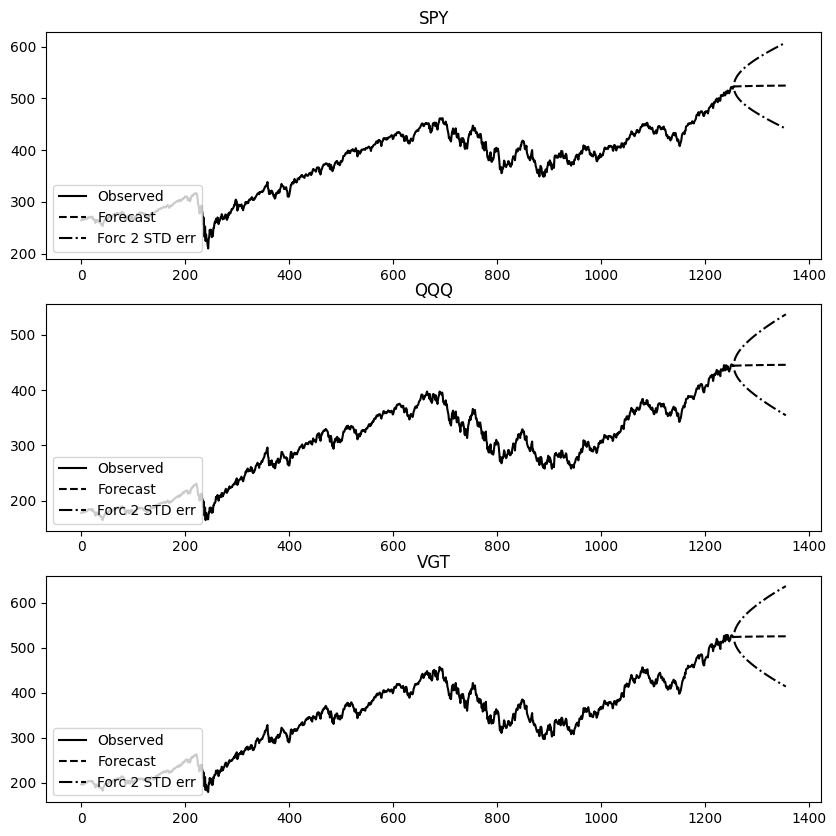

In [ ]:
# VEC Model Forecast of the SPY, QQQ, VGT.

vecm_model.plot_forecast(steps=100, alpha=0.05, plot_conf_int=True, n_last_obs=None)
plt.show()

In this last figure 6, we can see time series forecast in which SPY and QQQ are slightly up but VGT remains flat in the forecast.

In [ ]:
predictions = vecm_model.predict(steps=len(T1_df))

# Extract the predicted values for 'SPY', 'QQQ', and 'VGT'
predicted_spy = predictions[:, 0]
predicted_qqq = predictions[:, 1]
predicted_vgt = predictions[:, 2]

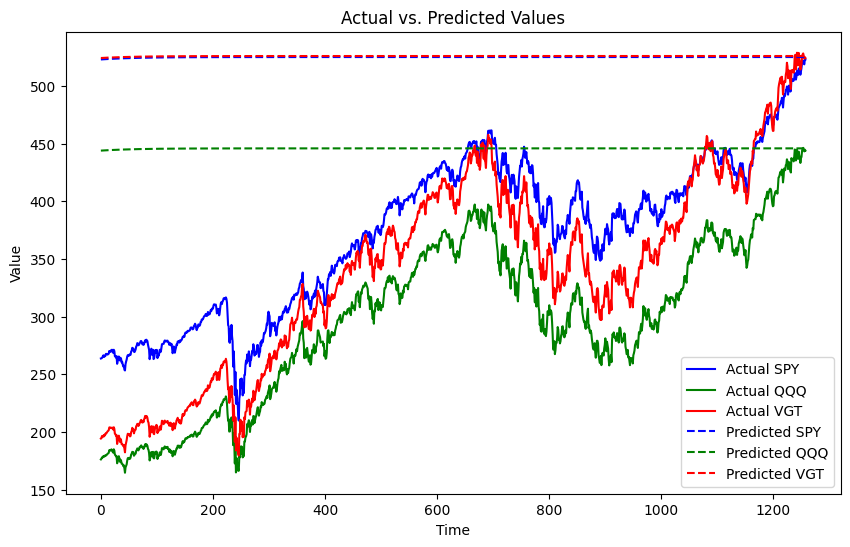

In [ ]:
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(T1_df.index, T1_df['SPY'], label='Actual SPY', color='blue')
plt.plot(T1_df.index, T1_df['QQQ'], label='Actual QQQ', color='green')
plt.plot(T1_df.index, T1_df['VGT'], label='Actual VGT', color='red')

# Plot predicted values
plt.plot(T1_df.index, predicted_spy, label='Predicted SPY', linestyle='--', color='blue')
plt.plot(T1_df.index, predicted_qqq, label='Predicted QQQ', linestyle='--', color='green')
plt.plot(T1_df.index, predicted_vgt, label='Predicted VGT', linestyle='--', color='red')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

Figure 7 also confirms our analysis of Figure 6.

## **Team Member 2**

For the modeling, I am going to use 5 years of daily data from 2019-2024 for Nifty 50, Infosys, Nifty IT Index data fetched from Yahoo Finance API.

In [ ]:
tickers = ['^NSEI', 'INFY.NS', '^CNXIT']

In [ ]:
T2_df = assets(tickers)
T2_df.rename(columns={"^NSEI": "NSE", "INFY.NS" : "INFY","^CNXIT": "IT"}, inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
T2_df.head()

,Date,NSE,INFY,IT
0,2019-04-01,11669.150391,671.111816,15840.650391
1,2019-04-02,11713.200195,674.933533,15988.400391
2,2019-04-03,11643.950195,669.511963,15962.950195
3,2019-04-04,11598.000000,664.712585,15744.799805
4,2019-04-05,11665.950195,674.844666,15923.049805


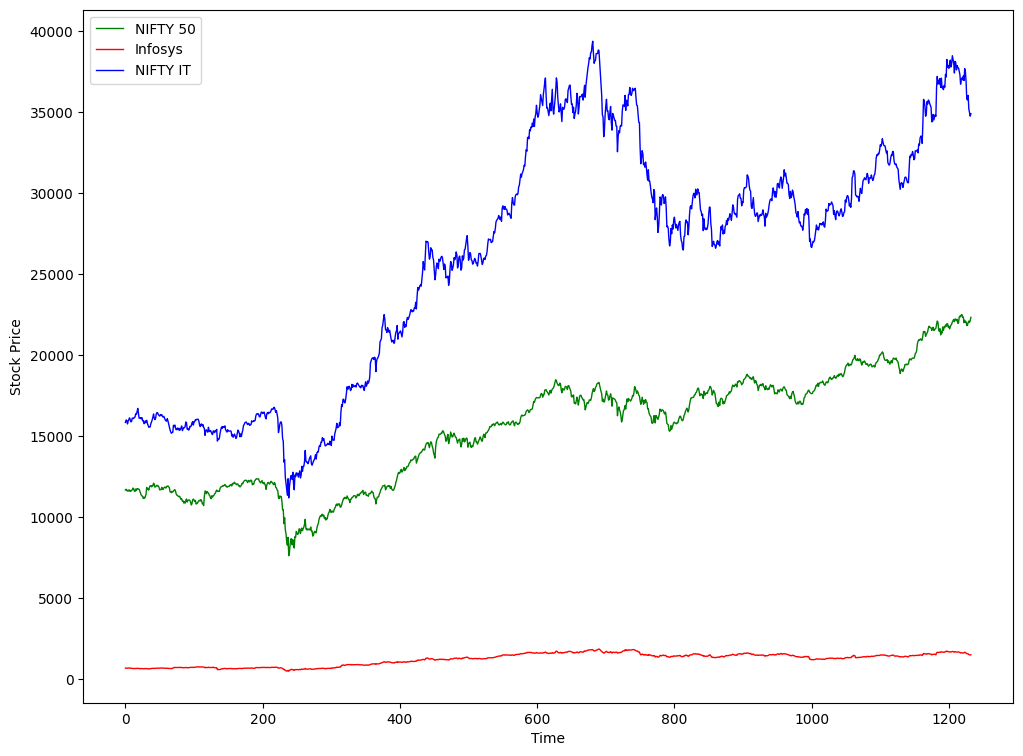

In [ ]:
plt.plot(T2_df["NSE"], linewidth=1, c="g", label="NIFTY 50")
plt.plot(T2_df["INFY"], linewidth=1, c="r", label="Infosys")
plt.plot(T2_df["IT"], linewidth=1, c="b", label="NIFTY IT")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

Let's perform ADF Test to check for stationarity and unit roots existence:

In [ ]:
# ADF Test Results with 5% Significance Level for NSE, INFY,IT
nifty_adf = ADF(T2_df["NSE"], trend="n", method="bic")
infy_adf = ADF(T2_df["INFY"], trend="n", method="bic")
niftyit_adf = ADF(T2_df["IT"], trend="n", method="bic")

pd.DataFrame(
    {
        "NSE": (nifty_adf.stat,  nifty_adf.critical_values["5%"]),
        "| INFY": (infy_adf.stat,  infy_adf.critical_values["5%"]),
        "| IT": (niftyit_adf.stat, niftyit_adf.critical_values["5%"])
    },
    index=["ADF Test Statistic", "5% Critical Value"],
)

,NSE,| INFY,| IT
ADF Test Statistic,1.892990,0.696645,1.145281
5% Critical Value,-1.941221,-1.941221,-1.941221


We can see that for all the stock and indices the Test Statistic > 5% Critical Value, thus, we can not reject the Null Hypotheses, and it has unit roots. Hence, as per the ADF test all the series are non-stationary.

In [ ]:
print(KPSS(T2_df['NSE'], trend="ct", lags=-1))
print(KPSS(T2_df['INFY'], trend="ct", lags=-1))
print(KPSS(T2_df['IT'], trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  0.276
P-value                         0.003
Lags                               23
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.930
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.711
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant and Linear Time T

As from the KPSS Test, we can see p-value < 0.05, thus, we can reject the null hypotheses, and thus thus the time series has unit root.Both tests conclude that the series is not stationary.

In [ ]:
# Selection of Number of Lags for VAR Model
vecm_data = pd.concat(
    [T2_df['NSE'],T2_df['INFY'],T2_df['IT']], axis=1
)

# Fit VAR model and run lag selection tool
model = VAR(vecm_data)
x = model.select_order(maxlags=7, trend="c")
x.summary()

,AIC,BIC,FPE,HQIC
0,40.82,40.84,5.362e+17,40.83
1,25.92,25.97*,1.806e+11,25.94*
2,25.91*,26.00,1.797e+11*,25.95
3,25.92,26.05,1.811e+11,25.97
4,25.93,26.10,1.829e+11,25.99
5,25.94,26.14,1.839e+11,26.01
6,25.94,26.18,1.845e+11,26.03
7,25.94,26.22,1.850e+11,26.05


From the above results, BIC and HQIC suggests lag = 1.

In [ ]:
# Johansen Trace Test Result
jtest = coint_johansen(vecm_data, det_order=0, k_ar_diff=1)
print(f"Eigenvalues of VECM coefficient matrix : {jtest.eig}\n")

pd.DataFrame(
    {
        "Test statistic": jtest.trace_stat,
        "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
        "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
        "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
    },
    index=["rank=0", "rank<=1", "rank<=2"]
)

Eigenvalues of VECM coefficient matrix : [0.00494967 0.00278789 0.0001    ]



,Test statistic,Critical values (90%),Critical values (95%),Critical values (99%)
rank=0,9.620843,27.0669,29.7961,35.4628
rank<=1,3.542438,13.4294,15.4943,19.9349
rank<=2,0.122508,2.7055,3.8415,6.6349


In [ ]:
# VECM model
vecm_model = VECM(endog=vecm_data, k_ar_diff=1, deterministic="ci").fit()
print(vecm_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation NSE
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.NSE         0.0128      0.037      0.344      0.731      -0.060       0.086
L1.INFY        0.5969      0.482      1.240      0.215      -0.347       1.541
L1.IT         -0.0388      0.029     -1.335      0.182      -0.096       0.018
Det. terms outside the coint. relation & lagged endog. parameters for equation INFY
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.NSE        -0.0125      0.005     -2.593      0.010      -0.022      -0.003
L1.INFY        0.0104      0.062      0.167      0.868      -0.112       0.133
L1.IT          0.0057      0.004      1.512      0.131      -0.002       0.013
Det. terms outside the coint. relation & la

The above results of the Johansen trace test shows the result for three tests: 𝐻0 : rank = 0 , 𝐻0 : rank = 1 , and 𝐻0 : rank = 2 . Let's use 5% as our decision point. For 𝐻0 : rank = 0 we can see the test statistic is 9.620845 and the 5% critical value is 29.7961. We can not reject 𝐻0 and say the rank is 0 or a cointegration relationship would exist. There is one linear combination of three time series variables that is stationary. The coefficients of the linear combination are in the second part under 'Cointegration relations for loading-coefficients-column 1' heading. We can write the linear combination as follows:

𝑆= -5006.0528 + 1⋅NSE + 31.5261⋅INFY - 1.8506⋅IT

The above equation is the deviation from the long-term equilibrium of the three time series. Let's check out the plot to see if this deviation is stationary.

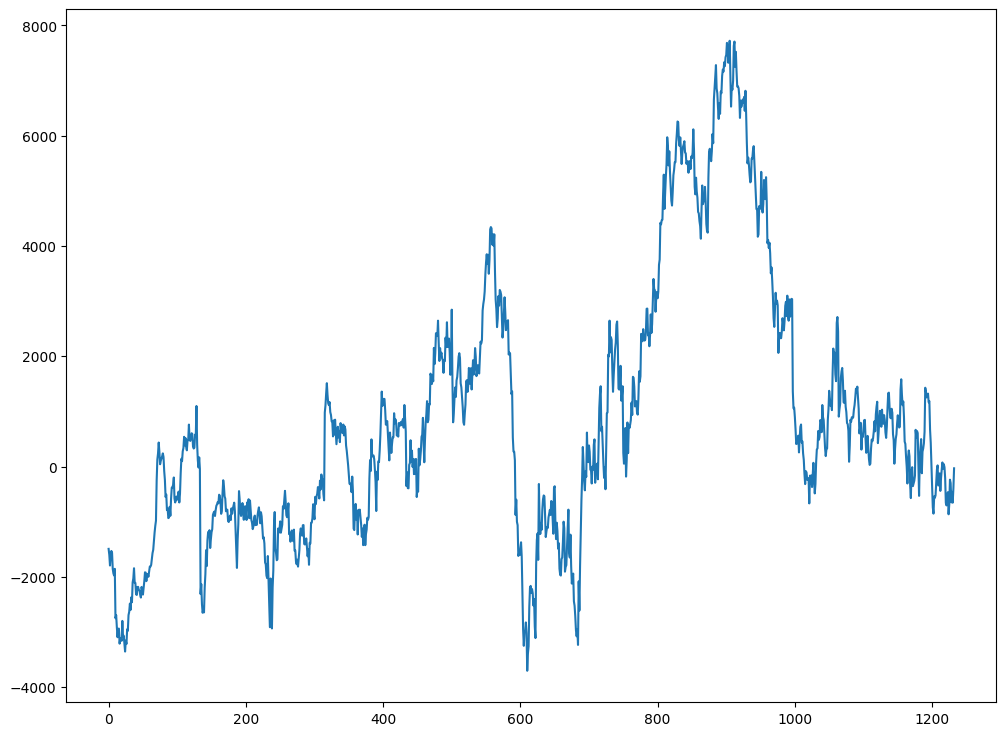

In [ ]:
# Time Plot for Deviation from Long-Term Equilibrium
"""
The precise coefficients of the linear combination are in:
vecm_model.const_coint and vecm_model.beta
𝑆= -5006.0528 + 1⋅NSE + 31.5261⋅INFY - 1.8506⋅IT
"""
S = (
    vecm_model.const_coint[0][0]
    + vecm_model.beta[0][0] * vecm_data.NSE
    + vecm_model.beta[1][0] * vecm_data.INFY
    + vecm_model.beta[2][0] * vecm_data.IT
)
plt.plot(S)
plt.show()

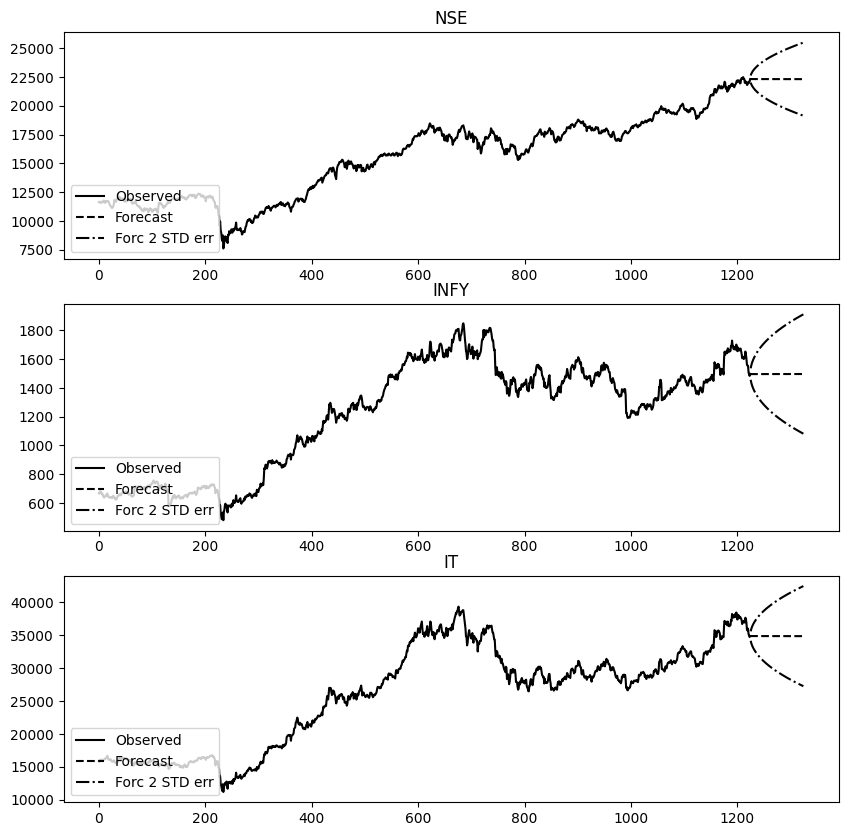

In [ ]:
vecm_model.plot_forecast(steps=100, alpha=0.05)
plt.show()

we can see the deviation from long-term equilibrium is moving within a channel. Let's take a look at the ADF test for the deviation.

In [ ]:
# ADF Test Result for Deviation from Long-Term Equilibrium
S_adf = ADF(S, trend="n", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", S_adf.regression.summary())
print("\nTest statistics and critical values: \n", S_adf)

Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              4.879
Date:                Mon, 08 Apr 2024   Prob (F-statistic):                      0.0274
Time:                        07:22:03   Log-Likelihood:                         -8788.3
No. Observations:                1226   AIC:                                  1.758e+04
Df Residuals:                    1225   BIC:                                  1.758e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

we can see that we easily reject that the deviation has a unit root because the test statistic (-2.209) is below 5% critical value (-1.94). P-value is < 0.05

## **Team Member 3**


**STOCKS CHOSEN:**

Apple Incorp (AAPL), Intel Corporation (INTC), and The Walt Disney Company (DIS).

The AAPL and INTC are NasdaqGS real time price datas, DIS is NYSE delayed price data. All the three categories are different. Apple is in Consumer Electronics, Intel is in semiconductor and Disney is in the entertainment industry.

In [ ]:
tickers = ['AAPL', 'INTC', 'DIS']

In [ ]:
T3_df = assets(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


**Figure 3.1:** Daily Price Data of Apple, Intel and Walt Disney Stock

In [ ]:
T3_df.head()

,Date,AAPL,INTC,DIS
0,2019-04-01,46.026638,47.702271,110.790527
1,2019-04-02,46.695717,47.571014,110.248924
2,2019-04-03,47.015808,48.551136,110.800369
3,2019-04-04,47.097637,48.936180,112.996284
4,2019-04-05,47.412914,48.656147,113.242462


**Figure 3.2:** Time series Line graph of  Price Data of Apple, Intel and Walt Disney Stock

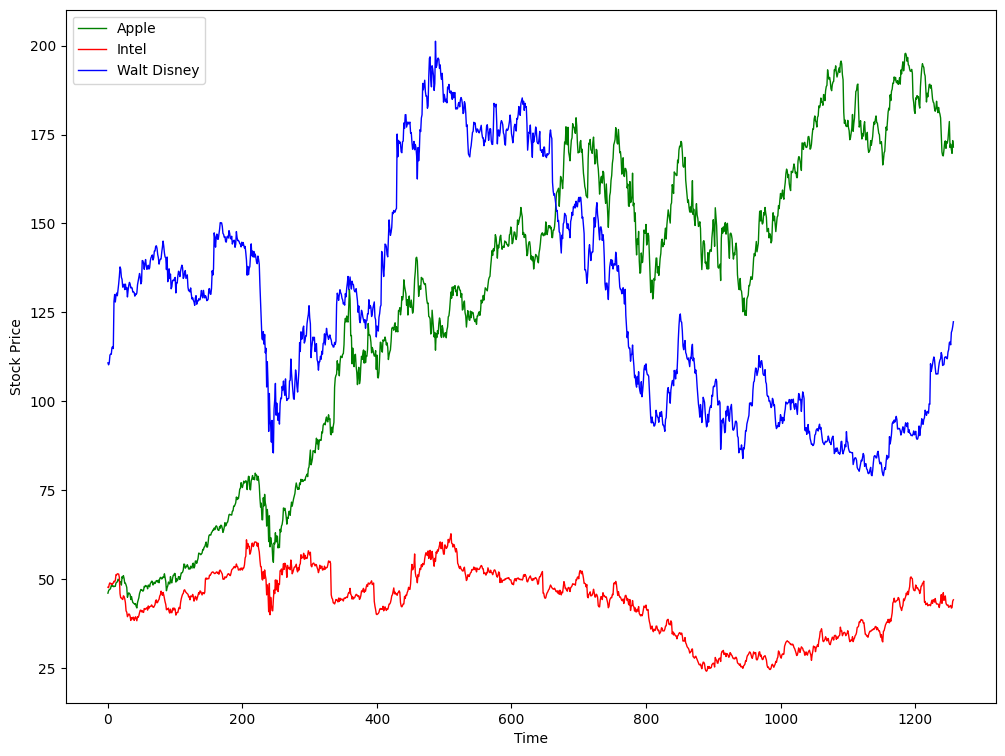

In [ ]:
plt.plot(T3_df["AAPL"], linewidth=1, c="g", label="Apple")
plt.plot(T3_df["INTC"], linewidth=1, c="r", label="Intel")
plt.plot(T3_df["DIS"], linewidth=1, c="b", label="Walt Disney")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test.

**Figure 3.3:** ADF Test for AAPL, INTC and DIS

In [ ]:
# ADF Test Results with 5% Significance Level for AAPL, INTC, DIS
aapl_adf = ADF(T3_df['AAPL'], trend="n", method="bic")
intc_adf = ADF(T3_df['INTC'], trend="n", method="bic")
dis_adf = ADF(T3_df['DIS'], trend="n", method="bic")


pd.DataFrame(
    {
        "Apple Inc.": (aapl_adf.stat,  aapl_adf.critical_values["5%"]),
        "| Intel Corp.": (intc_adf.stat,  intc_adf.critical_values["5%"]),
        "| Walt Disney Co.": (dis_adf.stat, dis_adf.critical_values["5%"],),
    },
    index=["ADF Test Statistic", "5% Critical Value"],
)

,Apple Inc.,| Intel Corp.,| Walt Disney Co.
ADF Test Statistic,0.857132,-0.482154,-0.238878
5% Critical Value,-1.941216,-1.941216,-1.941216


From figure 3.3, we can see that none of the financial assets has an ADF test statistic lower than 5% critical value. Hence, we cannot reject  𝐻0  hypothesis and there are unit roots in three time series. ADF test shows non stationary data. Now let us use KPSS test for the same issue of non stationarity.

**Figure 3.4:** KPSS Stationarity Test

In [ ]:
print(KPSS(T3_df['AAPL'], trend="ct", lags=-1))
print(KPSS(T3_df['INTC'], trend="ct", lags=-1))
print(KPSS(T3_df['DIS'], trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  0.776
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.478
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.776
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant and Linear Time T


Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test.
Both tests conclude that the series is not stationary - The series is not stationary

**Figure 3.5:** VAR Order Selection

In [ ]:
# Selection of Number of Lags for VAR Model
vecm_data = pd.concat(
    [T3_df['AAPL'], T3_df['INTC'], T3_df['DIS']], axis=1
)

# Fit VAR model and run lag selection tool
model = VAR(vecm_data)
x = model.select_order(maxlags=7, trend="c")
x.summary()

,AIC,BIC,FPE,HQIC
0,18.10,18.12,7.290e+07,18.11
1,3.433,3.482*,30.97,3.451
2,3.409,3.495,30.24,3.442*
3,3.408*,3.531,30.21*,3.454
4,3.416,3.576,30.46,3.477
5,3.426,3.623,30.77,3.500
6,3.432,3.666,30.94,3.520
7,3.436,3.706,31.05,3.538


From figure 3.5, we can see all the information criteria select lag 3 for the level of the VAR model.

Now let's check Johansen trace test results.

**Figure 3.6**: VECM Coefficient Matrix (Johansen Trace Test)

In [ ]:
# Johansen Trace Test Result for AAPL, INTC and DIS
jtest = coint_johansen(vecm_data, det_order=0, k_ar_diff=1)
# Print the results
print(f"Eigenvalues of VECM coefficient matrix : {jtest.eig}\n")

pd.DataFrame(
    {
        "Test statistic": jtest.trace_stat,
        "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
        "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
        "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
    },
    index=["rank=0", "rank<=1", "rank<=2"],
)

Eigenvalues of VECM coefficient matrix : [0.00550217 0.00345251 0.00098268]



,Test statistic,Critical values (90%),Critical values (95%),Critical values (99%)
rank=0,12.508523,27.0669,29.7961,35.4628
rank<=1,5.578712,13.4294,15.4943,19.9349
rank<=2,1.234858,2.7055,3.8415,6.6349


**Figure 3.6:** VECM Model

In [ ]:
# VECM model
vecm_model = VECM(endog=vecm_data, k_ar_diff=1, deterministic="ci").fit()
print(vecm_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation AAPL
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.AAPL        0.0289      0.033      0.889      0.374      -0.035       0.093
L1.INTC       -0.1993      0.072     -2.778      0.005      -0.340      -0.059
L1.DIS        -0.0446      0.029     -1.543      0.123      -0.101       0.012
Det. terms outside the coint. relation & lagged endog. parameters for equation INTC
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.AAPL       -0.0235      0.015     -1.611      0.107      -0.052       0.005
L1.INTC       -0.1174      0.032     -3.648      0.000      -0.180      -0.054
L1.DIS        -0.0138      0.013     -1.066      0.286      -0.039       0.012
Det. terms outside the coint. relation & l

In [ ]:
# VECM model
vecm_model = VECM(endog=vecm_data, k_ar_diff=1, deterministic="ci").fit()
print(vecm_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation AAPL
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.AAPL        0.0289      0.033      0.889      0.374      -0.035       0.093
L1.INTC       -0.1993      0.072     -2.778      0.005      -0.340      -0.059
L1.DIS        -0.0446      0.029     -1.543      0.123      -0.101       0.012
Det. terms outside the coint. relation & lagged endog. parameters for equation INTC
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.AAPL       -0.0235      0.015     -1.611      0.107      -0.052       0.005
L1.INTC       -0.1174      0.032     -3.648      0.000      -0.180      -0.054
L1.DIS        -0.0138      0.013     -1.066      0.286      -0.039       0.012
Det. terms outside the coint. relation & l

Figure 3.6 shows the result of the Johansen trace test. The top part in Figure 3.6 shows the result for three tests:  𝐻0
 : rank =  0
 ,  𝐻0
 : rank =  1
 , and  𝐻0
 : rank =  2
 . Let's use 5% as our decision point. For  𝐻0
 : rank =  0
  we can see the test statistic is 12.508522	and the 5% critical value is 29.7961. We can not reject  𝐻0
  and say the rank is 0 or a cointegration relationship would exist.
 There is one linear combination of three time series variables that is stationary. The coefficients of the linear combination are in the second part under 'Cointegration relations for loading-coefficients-column 1' heading. We can write the linear combination as follows:

𝑆=1.011e+04+1⋅AAPL+188.8112⋅INTC-813.5078⋅DIS

The above equation is the deviation from the long-term equilibrium of the three time series. Let's check out the plot to see if this deviation is stationary.

**Figure 3.7:** Time Plot for Deviation from Long-Term Equilibrium

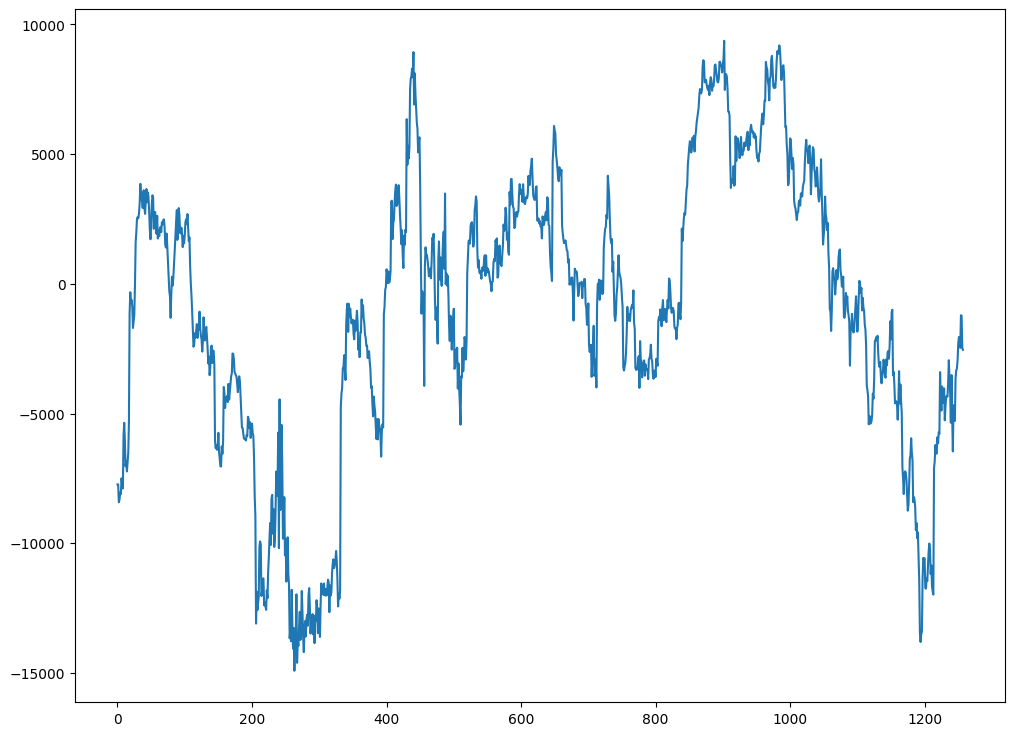

In [ ]:
# Time Plot for Deviation from Long-Term Equilibrium
"""
The precise coefficients of the linear combination are in:
vecm_model.const_coint and vecm_model.beta
𝑆=1.011e+04+1*AAPL+188*8112⋅INTC-813*5078⋅DIS
"""
S = (
    vecm_model.const_coint[0][0]
    + vecm_model.beta[0][0] * vecm_data.AAPL
    + vecm_model.beta[1][0] * vecm_data.INTC
    + vecm_model.beta[2][0] * vecm_data.DIS
)
plt.plot(S)
plt.show()

From figure 3.7, we can see the deviation from long-term equilibrium is moving within a channel. Let's take a look at the ADF test for the deviation.

**Figure 3.8:** ADF Test Result for Deviation from Long-Term Equilibrium

In [ ]:
# ADF Test Result for Deviation from Long-Term Equilibrium
S_adf = ADF(S, trend="n", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", S_adf.regression.summary())
print("\nTest statistics and critical values: \n", S_adf)

Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.020
Model:                            OLS   Adj. R-squared (uncentered):              0.019
Method:                 Least Squares   F-statistic:                              12.94
Date:                Mon, 08 Apr 2024   Prob (F-statistic):                    2.75e-06
Time:                        07:22:05   Log-Likelihood:                         -10237.
No. Observations:                1256   AIC:                                  2.048e+04
Df Residuals:                    1254   BIC:                                  2.049e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

From figure 3.8, we can see that we easily reject that the deviation has a unit root because the test statistic (-2.580) is below 5% critical value (-1.94). P-value is < 0.05

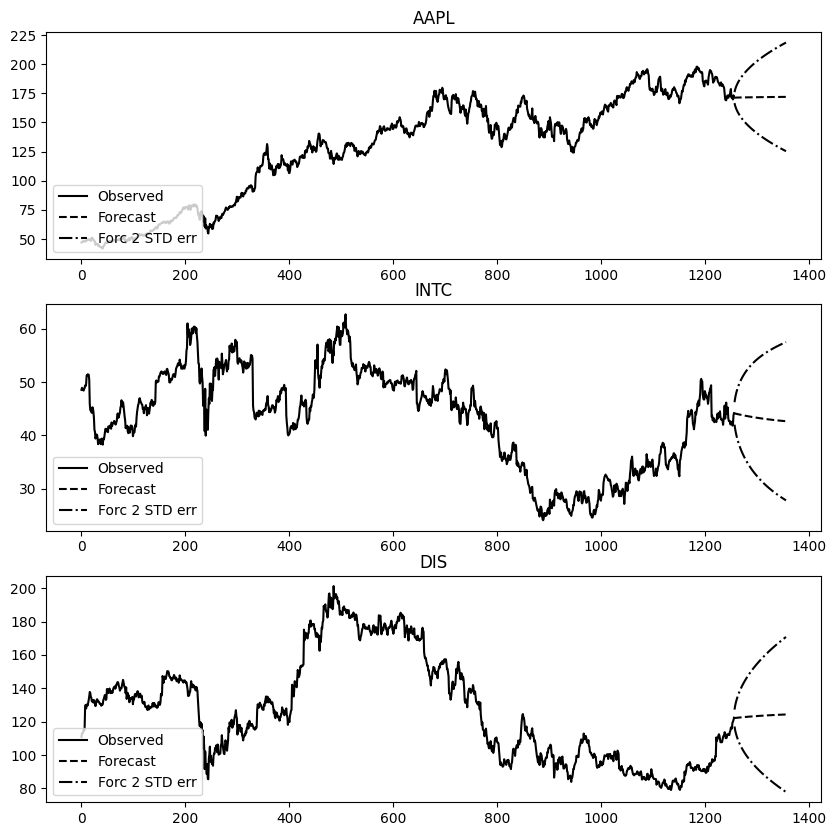

In [47]:
vecm_model.plot_forecast(steps=100, alpha=0.05)
plt.show()